  # Apply encoder to morphological profiles to get latent space representations :

# Setup

In [1]:
%load_ext autoreload  
%autoreload 2
from IPython.display import display, HTML, Image
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:98% !important; }</style>"))
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import csv
import json
import time
import types
import copy
import pprint
import logging
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)

import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn.functional as F
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)


pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-MAIN-SNNL.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

insert ./src
insert ../..
['../..', './src', '/home/kevin/WSL-shared/cellpainting/cj-datasets', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']


In [ ]:
# import snnl.utils as utils
# from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from KevinsRoutines.utils.utils_general import list_namespace, save_to_pickle, load_from_pickle

from src.utils.utils_cellpainting import (model_selection, balance_datasets, label_counts, compute_metrics,
                                          plots_from_estimator, plots_from_predictions)

In [4]:
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as sps
from   scipy.spatial.distance import pdist, squareform, euclidean

# from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_fscore_support
# from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
# Models
from xgboost import XGBClassifier, XGBRegressor

import sklearn.metrics as skm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.utils.random as skr


from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# utility class to help normalize labels such that they contain only values between 0 and n_classes-1.
from sklearn.preprocessing import LabelEncoder

# K-Folds cross-validator - Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
# Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.model_selection import ShuffleSplit, GroupShuffleSplit, StratifiedShuffleSplit, TimeSeriesSplit

# Evaluate metric(s) by cross-validation and also record fit/score times.
from sklearn.model_selection import cross_validate, cross_val_score

# Generate cross-validated estimates for each input data point.
# The data is split according to the cv parameter. Each sample belongs to exactly one test set,
# and its prediction is computed with an estimator fitted on the corresponding training set.
from sklearn.model_selection import cross_val_predict

# Exhaustive search over specified parameter values for an estimator.
# Randomized search on hyper parameters.
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Input checker utility for building a cross-validator.(?)
from sklearn.model_selection._split import check_cv

from sklearn.pipeline import Pipeline

# Make a scorer from a performance metric or loss function. This factory function wraps scoring
# functions for use in GridSearchCV and cross_val_score. It takes a score function, such as accuracy_score,
# mean_squared_error, adjusted_rand_score or average_precision_score and returns a callable that
# scores an estimator’s output. The signature of the call is (estimator, X, y) where estimator
# is the model to be evaluated, X is the data and y is the ground truth labeling (or None in the
# case of unsupervised models).
from sklearn.metrics import make_scorer

# regression matrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# classification metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# from sklearn.base import BaseEstimator
# from sklearn.base import ClassifierMixin
# from sklearn.base import TransformerMixin

# Construct a new unfitted estimator with the same parameters. Clone does a deep copy of the model
# in an estimator without actually copying attached data. It returns a new estimator with the same
# parameters that has not been fitted on any data.
# from sklearn.base import clone
from sklearn.preprocessing import StandardScaler


In [6]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" Pandas version: {pd.__version__}  ")


2024-11-04 17:14:08,889 - __main__ - INFO: -  Excution started : 2024_11_04_17:14:08 
2024-11-04 17:14:08,890 - __main__ - INFO: -  Pytorch version  : 2.2.0
2024-11-04 17:14:08,891 - __main__ - INFO: -  Scipy version    : 1.11.4  		 Numpy version : 1.26.2
2024-11-04 17:14:08,892 - __main__ - INFO: -  Pandas version: 2.2.0  


In [7]:
from utils.jcp_datasets import project_datasets, display_project_datasets
ds = project_datasets(output_path = '../output_10162023/')
display_project_datasets(ds)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


 Path and Prefixes : 
 ------------------- 
 prefix                                      : 
 prefix_lc                                   : 
 metadata path                               : ./metadata/
 input path                                  : ./input/
 output path                                 : ./output_10162023/

 Input & Metadata Datasets : 
 --------------------------- 
 Compound Metadata Input File                : ./metadata/compound.csv
 Plate Metadata Input File                   : ./metadata/plate_new.csv
 Well Metadata Input File                    : ./metadata/well.csv

 Profiles Metadata File                      : ./metadata/profile_metadata.pkl
 Parquet  Metadata File                      : ./metadata/parquet_columns.pkl

 Compound Metadata : 
 ------------------- 
 Metadata + Smiles                           : ./output_10162023/compound_metadata_smiles.csv
          + TPSA                             : ./output_10162023/compound_metadata_tpsa.csv
          + TPSA Cl

In [59]:
WANDB_ACTIVE  = False
DATE          = 'yyyymmdd-hhmm'

# CHECKPT       = "AE_snnl_dcpb200_150Ltnt_512_240709_2235_LAST_ep_705.pt"
# RUN_ID        = "jzt6ecjz"
PROFILES_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/"
MODEL_SAVE_PATH = f"./saved_fingerprint_models/profile_models"

LATENT_DIM    = 1471
METADATA_COLS = ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well'  , 'Metadata_JCP2022', 
                 'Metadata_Hash'  , 'Metadata_Bin'  , 'Metadata_TPSA' , 'Metadata_lnTPSA', 'Metadata_log10TPSA', 
                 'Metadata_Permiation']

# METADATA_COLS += [f'Feature_{x:03d}' for x in range(LATENT_DIM)]
INPUT_COLS = LATENT_DIM + len(METADATA_COLS)
print(len(METADATA_COLS))
print(INPUT_COLS)


## AUTOENCODER RUNMODE 
# AE_RUNMODE = "snnl"
# AE_RUNMODE = 'base'
## 
# AE_DATETIME = "20240906_2201"     # SNNL, CPB = 600, Latent 150, WD = 0.001, SNN Factor 3
# AE_DATETIME = "20240917_2004"     # SNNL, CPB = 600, Latent 250, WD = 0.001, SNN Factor 3
##
# AE_CKPTTYPE = "BEST"
# AE_CKPTTYPE = "LAST"
# df_header = pd.read_csv(HEADER_FILE).columns.to_list()
# header_cols

11
1482


In [13]:
# = utils.load_model_from_ckpt(model, ex_mode, ex_timestamp, ex_title, epochs, ex_cpb, ex_factor )

FINGERPRINTS_TRAINING_FILE   = f"3sample_pharmacophores_{INPUT_COLS}_HashOrder_training.csv"
FINGERPRINTS_VALIDATION_FILE = f"3sample_pharmacophores_{INPUT_COLS}_HashOrder_validation.csv"
FINGERPRINTS_TEST_FILE       = f"3sample_pharmacophores_{INPUT_COLS}_HashOrder_test.csv"

print(FINGERPRINTS_TRAINING_FILE)
print(FINGERPRINTS_VALIDATION_FILE)
print(FINGERPRINTS_TEST_FILE)

PROFILES_TRAINING_FILE   = f"3sample_profiles_{INPUT_COLS}_HashOrder_training.csv"
PROFILES_VALIDATION_FILE = f"3sample_profiles_{INPUT_COLS}_HashOrder_validation.csv"
PROFILES_TEST_FILE       = f"3sample_profiles_{INPUT_COLS}_HashOrder_test.csv"

print(PROFILES_TRAINING_FILE)
print(PROFILES_VALIDATION_FILE)
print(PROFILES_TEST_FILE)

3sample_pharmacophores_1482_HashOrder_training.csv
3sample_pharmacophores_1482_HashOrder_validation.csv
3sample_pharmacophores_1482_HashOrder_test.csv
3sample_profiles_1482_HashOrder_training.csv
3sample_profiles_1482_HashOrder_validation.csv
3sample_profiles_1482_HashOrder_test.csv


In [15]:
TRAIN_INPUT_X = os.path.join(PROFILES_INPUT_PATH, PROFILES_TRAINING_FILE)
TRAIN_INPUT_Y = os.path.join(FINGERPRINT_INPUT_PATH, FINGERPRINT_TRAINING_FILE)
TRAIN_INPUT_X
TRAIN_INPUT_Y

# TEST_INPUT_X  = os.path.join(PROFILES_INPUT_PATH, PROFILES_TEST_FILE)
# TEST_INPUT_Y  = os.path.join(PROFILES_INPUT_PATH, FINGERPRINTS_TEST_FILE)
# TEST_INPUT_X
# TEST_INPUT_Y

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_training.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_pharmacophores_1482_HashOrder_training.csv'

In [18]:
# BEST_OUTPUT_FILE = BASELINE_BEST_OUTPUT_FILE
# LAST_OUTPUT_FILE = BASELINE_LAST_OUTPUT_FILE

# OUTPUT_FILE = SNNL_LAST_OUTPUT_FILE
# INPUT_FILE = SNNL_BEST_INPUT_FILE
# for runmode in ['BASELINE', 'SNNL']:
#     for datatype in ['train', 'test']:
#         print(os.path.join(PROFILES_INPUT_PATH, INPUT_FILE.format(runmode = runmode, datatype=datatype)))
#         # print(os.path.join(PROFILES_INPUT_PATH, LAST_OUTPUT_FILE.format(datatype=datatype)))

## Helper routines

In [ ]:
# sample_idxs = skr.sample_without_replacement(n_population=100, n_samples= 10 )

# rng = np.random.default_rng()

# indxs = rng.choice(100, [10,10], replace = False)
# indxs

### Create Pharmacophores definitions 

In [106]:
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
print(fdefName)
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)
sigFactory = SigFactory(featFactory,minPointCount=2,maxPointCount=3)
fingerprint_bins = [(0,1),(1,2),(2,3),(3,4),(4,100)]
# fingerprint_bins = [(0,3),(3,8)]
sigFactory.SetBins(fingerprint_bins)
sigFactory.Init()
FINGERPRINT_LENGTH = sigFactory.GetSigSize()
bit_id = 0


print(f" Bins : {fingerprint_bins}   Size of fingerprint: {FINGERPRINT_LENGTH}")
# print(f" Bins : {bit_id:4d}   description:  {sigFactory.GetBitDescription(bit_id)}")

2024-12-15 11:23:27,183 - rdkit - INFO: - Enabling RDKit 2023.03.3 jupyter extensions


/home/kevin/miniforge3/envs/cp311/share/RDKit/Data/BaseFeatures.fdef
 Bins : [(0, 1), (1, 2), (2, 3), (3, 4), (4, 100)]   Size of fingerprint: 13740


In [47]:
# sample_idxs = skr.sample_without_replacement(n_population=100, n_samples= 10 )
# rng = np.random.default_rng()
# indxs = rng.choice(100, [10,10], replace= False)
# indxs

indices_pct_bw_10_90
selected_label_indices = np.array([    2,     3,     4,     6,     7,     8,    12,    13,    14,    17,    18,    21,    22,    23,    24,    33,    34,    41,    42,    43,
                                      44,    46,    47,    48,    49,    51,    52,    53,    54,    56,    57,    58,    59,    67,    69,    77,    78,    79,    82,    83,
                                      84,    86,    87,    88,    89,    99,   106,   107,   108,   109,   111,   112,   113,   114,   122,   124,   133,   134,   144,   290,
                                     291,   292,   347,   359,   383,   392,   397,   398,   402,   403,   404,   405,   472,   496,   511,   516,   517,   518,   573,   579,
                                     585,   608,   609,   619,   624,   629,   630,   631,   686,   698,   722,   731,   736,   741,   742,   743,   744,   970,  1163,  1180,
                                    1181,  1183,  1186,  1191,  1193,  1195,  1196,  1236,  1237,  1238,  1251,  1263,  1274,  1287,  1299,  1304,  1306,  1307,  1308,  1309,
                                    1348,  1349,  1350,  1351,  1373,  1375,  1376,  1387,  1389,  1400,  1410,  1411,  1412,  1414,  1416,  1417,  1419,  1420,  1421,  1422,
                                    1464,  1483,  1489,  1502,  1513,  1520,  1525,  1530,  1532,  1534,  1535,  1761,  1977,  1982,  1985,  1986,  1987,  2042,  2048,  2052,
                                    2053,  2054,  2076,  2078,  2088,  2089,  2090,  2093,  2095,  2098,  2099,  2100,  2155,  2159,  2167,  2191,  2196,  2198,  2203,  2208,
                                    2210,  2211,  2212,  2213,  2439,  2630,  2653,  2654,  2655,  2657,  2658,  2660,  2662,  2663,  2664,  2665,  2726,  2732,  2756,  2763,
                                    2768,  2773,  2775,  2776,  2777,  2778,  2958,  3002,  3004,  3215,  3220,  3225,  3230,  3456,  4357,  4402,  4470,  4471,  4472,  4473,
                                    4515,  4583,  4584,  4585,  4586,  4628,  4696,  5136,  5141,  5146,  5149,  5151,  5193,  5216,  5218,  5225,  5242,  5249,  5252,  5254,
                                    5259,  5262,  5263,  5264,  5306,  5331,  5355,  5362,  5374,  5375,  5376,  5377,  5765,  5814,  5819,  5821,  5824,  5826,  5827,  5828,
                                    5829,  5871,  5896,  5920,  5927,  5939,  5940,  5941,  5942,  6379,  7591,  7615,  7635,  7636,  7637,  7748,  7749,  7750,  8167,  8190,
                                    8191,  8192,  8194,  8197,  8199,  8200,  8201,  8202,  8269,  8293,  8300,  8305,  8310,  8312,  8314,  8315,  8757,  8762,  8767,  9833,
                                    9862,  9894,  9895,  9896,  9897,  9939,  9964,  9988, 10007, 10008, 10009, 10010, 10447, 10457, 10462])


str_selected_label_indices  = [str(x) for x in selected_label_indices ]
# str_selected_label_indicies 

array([    2,     3,     4,     6,     7,     8,    12,    13,    14,    17,    18,    21,    22,    23,    24,    33,    34,    41,    42,    43,
          44,    46,    47,    48,    49,    51,    52,    53,    54,    56,    57,    58,    59,    67,    69,    77,    78,    79,    82,    83,
          84,    86,    87,    88,    89,    99,   106,   107,   108,   109,   111,   112,   113,   114,   122,   124,   133,   134,   144,   290,
         291,   292,   347,   359,   383,   392,   397,   398,   402,   403,   404,   405,   472,   496,   511,   516,   517,   518,   573,   579,
         585,   608,   609,   619,   624,   629,   630,   631,   686,   698,   722,   731,   736,   741,   742,   743,   744,   970,  1163,  1180,
        1181,  1183,  1186,  1191,  1193,  1195,  1196,  1236,  1237,  1238,  1251,  1263,  1274,  1287,  1299,  1304,  1306,  1307,  1308,  1309,
        1348,  1349,  1350,  1351,  1373,  1375,  1376,  1387,  1389,  1400,  1410,  1411,  1412,  1414,  1416,  1417,

### Create Pharmacophores definitions 

In [111]:
selected_label_descriptions = []
print()
print(f"  Bit    ROC_AUC     Description")
print(f"  ----   --------    -------------")
# for bit_id in range(200, 400): # bits 200 to 400
for bit_id in sorted(selected_label_indices):
    # if bit_id in selected_bits_over60:
    #     prefix = " > 0.60  "
    # elif bit_id in selected_bits_55_to_60:
    #     prefix = " > 0.55  "
    # elif bit_id in selected_bits_50_to_55:
    #     prefix = " > 0.50  "
    # else :
    prefix = "         "
    selected_label_descriptions.append(sigFactory.GetBitDescription(bit_id))
    print(f" {bit_id:5d}   {prefix:9s}    {selected_label_descriptions[-1]}")


  Bit    ROC_AUC     Description
  ----   --------    -------------
     2                Acceptor Acceptor |0 2|2 0|
     3                Acceptor Acceptor |0 3|3 0|
     4                Acceptor Acceptor |0 4|4 0|
     6                Acceptor Aromatic |0 1|1 0|
     7                Acceptor Aromatic |0 2|2 0|
     8                Acceptor Aromatic |0 3|3 0|
    12                Acceptor Donor |0 2|2 0|
    13                Acceptor Donor |0 3|3 0|
    14                Acceptor Donor |0 4|4 0|
    17                Acceptor Hydrophobe |0 2|2 0|
    18                Acceptor Hydrophobe |0 3|3 0|
    21                Acceptor LumpedHydrophobe |0 1|1 0|
    22                Acceptor LumpedHydrophobe |0 2|2 0|
    23                Acceptor LumpedHydrophobe |0 3|3 0|
    24                Acceptor LumpedHydrophobe |0 4|4 0|
    33                Acceptor PosIonizable |0 3|3 0|
    34                Acceptor PosIonizable |0 4|4 0|
    41                Aromatic Aromatic |0 1|1

# Load Datasets - Embedded Features CSV files

## Training Data

In [17]:
df_train_x = pd.read_csv(TRAIN_INPUT_X)
# df_train = pd.read_csv(TRAIN_INPUT, nrows = 100 )
# df_train = pd.read_csv(TRAIN_INPUT, usecols = ['Metadata_Batch'])

In [32]:
df_train_x.shape
df_train_x.info()
# df_train_x.iloc[:5,0:13]
# df_train_x.head(10)
# df_train_x.tail(10)

(277200, 1482)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277200 entries, 0 to 277199
Columns: 1482 entries, Metadata_Source to Nuclei_Texture_SumVariance_RNA_10_01_256
dtypes: float64(1474), int64(3), object(5)
memory usage: 3.1+ GB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_Center_X
0,source_1,Batch5_20221030,UL001793,M26,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0,-0.422301,-0.414977
1,source_10,2021_06_22_U2OS_48_hr_run8,Dest210622-143628,M04,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0,-0.634604,-0.623231
2,source_3,CP_31_all_Phenix1,B040603b,G13,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0,0.510761,0.556297
3,source_6,p211004CPU2OS48hw384exp031JUMP,110000295562,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,0,-1.832139,-1.829487
4,source_3,CP_32_all_Phenix1,B40003aW,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,0,-1.167907,-1.244004


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,...,Nuclei_Texture_SumAverage_DNA_10_01_256,Nuclei_Texture_SumAverage_ER_10_01_256,Nuclei_Texture_SumAverage_Mito_10_01_256,Nuclei_Texture_SumAverage_RNA_10_01_256,Nuclei_Texture_SumEntropy_DNA_10_03_256,Nuclei_Texture_SumVariance_AGP_10_03_256,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_RNA_10_01_256
0,source_1,Batch5_20221030,UL001793,M26,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,...,0.443768,0.062235,-0.648585,0.308744,0.073046,-0.245728,0.099481,-0.107570,-0.558575,0.174041
1,source_10,2021_06_22_U2OS_48_hr_run8,Dest210622-143628,M04,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,...,1.705322,3.242936,-1.327198,1.111929,2.102121,1.878933,3.540586,2.529848,-1.022145,0.753343
2,source_3,CP_31_all_Phenix1,B040603b,G13,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,...,-0.408875,-0.214203,-0.092149,-0.658746,-0.453523,5.058665,-0.418815,-0.455386,0.699883,-0.680918
3,source_6,p211004CPU2OS48hw384exp031JUMP,110000295562,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,...,-0.438654,-0.627846,-0.707734,-0.504685,-0.398547,-0.303720,-0.389571,0.922415,-0.724165,-0.202291
4,source_3,CP_32_all_Phenix1,B40003aW,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,...,0.683232,-0.350120,0.300466,-0.384838,0.766679,-0.162195,-0.055417,-0.199495,4.481964,-0.165720
5,source_10,2021_08_23_U2OS_48_hr_run18,Dest210823-174733,I13,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,...,-0.385001,-0.620632,-0.703596,-0.348666,-0.692979,0.238075,-0.492878,-0.662979,-0.251163,-0.245822
6,source_1,Batch6_20221102,UL000587,O34,JCP2022_051160,-9223005963369866647,9,68.54,4.227418,1.835944,...,-1.358390,-0.948076,-1.779347,-1.717747,-1.499519,-0.395883,-0.842981,-0.349826,-0.925387,-0.687635
7,source_6,p211109CPU2OS48hw384exp035JUMP,110000296167,H17,JCP2022_051160,-9223005963369866647,9,68.54,4.227418,1.835944,...,-0.309675,0.356243,-0.550914,-0.129928,-0.289333,0.247451,-0.187486,-0.203569,-0.008298,-0.340577
8,source_3,CP_26_all_Phenix1,J12455b,H17,JCP2022_051160,-9223005963369866647,9,68.54,4.227418,1.835944,...,0.270542,-0.265563,-0.349706,-0.242253,0.212501,-0.225538,-0.052160,-0.232956,-0.158716,-0.185053
9,source_2,20210712_Batch_5,1053597875,K10,JCP2022_038591,-9222975330808494972,4,51.22,3.936130,1.709440,...,0.919958,1.159541,0.540352,0.923058,1.803371,0.638770,1.548086,0.621993,-0.278182,0.397897


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,...,Nuclei_Texture_SumAverage_DNA_10_01_256,Nuclei_Texture_SumAverage_ER_10_01_256,Nuclei_Texture_SumAverage_Mito_10_01_256,Nuclei_Texture_SumAverage_RNA_10_01_256,Nuclei_Texture_SumEntropy_DNA_10_03_256,Nuclei_Texture_SumVariance_AGP_10_03_256,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_RNA_10_01_256
277190,source_9,20211102-Run15,GR00004398,J35,JCP2022_089792,5548393758141673059,3,100.28,4.607966,2.001214,...,-1.227611,-1.127899,-0.693571,-1.062077,-0.255365,-0.795033,-0.145296,-0.036792,-0.026761,-0.399984
277191,source_3,CP_29_all_Phenix1,SP28P31d,L08,JCP2022_054246,5548833810863940256,0,83.10,4.420045,1.919601,...,0.292397,-0.188853,-0.181736,-0.128789,0.435171,-1.011592,0.165799,-0.875260,-0.738167,-0.845481
277192,source_1,Batch6_20221102,UL000595,X16,JCP2022_054246,5548833810863940256,0,83.10,4.420045,1.919601,...,1.135885,0.198351,0.023506,0.741274,0.634675,0.198494,0.690828,0.453840,0.436868,0.349392
277193,source_10,2021_08_23_U2OS_48_hr_run18,Dest210823-175355,G13,JCP2022_054246,5548833810863940256,0,83.10,4.420045,1.919601,...,0.279360,0.891108,1.169465,0.907916,0.184572,-0.405127,-0.268694,1.305635,-0.381450,0.174232
277194,source_6,p211109CPU2OS48hw384exp035JUMP,110000295497,G21,JCP2022_040737,5548902807653184645,5,55.55,4.017284,1.744684,...,-0.499957,-0.459356,-0.122929,-0.514149,-0.299461,-0.186935,-0.204694,-0.260950,-0.123887,-0.230385
277195,source_8,J3,A1170503,G21,JCP2022_040737,5548902807653184645,5,55.55,4.017284,1.744684,...,0.370676,-0.556230,-0.191734,-0.675387,0.408261,-0.356981,-0.077135,-0.290681,-0.331243,-0.663728
277196,source_10,2021_08_17_U2OS_48_hr_run16,Dest210809-140929,N19,JCP2022_040737,5548902807653184645,5,55.55,4.017284,1.744684,...,0.279704,-0.477297,0.766346,-0.538395,0.534544,-0.168472,0.167678,5.556482,0.234914,0.033930
277197,source_5,JUMPCPE-20211001-Run34_20211003_121618,APTJUM513,I14,JCP2022_100922,5548998150937919747,3,79.96,4.381527,1.902873,...,1.355798,0.717887,0.582572,0.980785,1.483980,0.776554,1.503725,0.131455,0.991715,0.536435
277198,source_11,Batch1,EC000029,J07,JCP2022_100922,5548998150937919747,3,79.96,4.381527,1.902873,...,1.222598,2.746357,-0.969408,1.989859,2.133944,0.750914,0.038839,0.516236,-0.378281,0.546976
277199,source_5,JUMPCPE-20210706-Run06_20210706_235916,APTJUM213,I14,JCP2022_100922,5548998150937919747,3,79.96,4.381527,1.902873,...,0.575722,-0.627173,-1.028061,-2.295289,0.119773,0.577766,0.641044,0.361389,-0.855551,-1.424477


In [43]:
df_train_y = pd.read_csv(TRAIN_INPUT_Y)
# df_train = pd.read_csv(TRAIN_INPUT, nrows = 100 )
# df_train = pd.read_csv(TRAIN_INPUT, usecols = ['Metadata_Batch'])

In [44]:
df_train_y.shape
df_train_y.info()
df_train_y.iloc[ :10,:14]
df_train_y.iloc[-10:,:14]

(277200, 1035)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277200 entries, 0 to 277199
Columns: 1035 entries, Metadata_JCP2022 to 1031
dtypes: int64(1034), object(1)
memory usage: 2.1+ GB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,7,8,9,10
0,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,1,1,1,0
1,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,1,1,1,0
2,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,1,1,1,0
3,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,1,1,0,0
4,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,1,1,0,0
5,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,1,1,0,0
6,JCP2022_051160,-9223005963369866647,9,0,1,1,1,1,1,1,1,0,1,0
7,JCP2022_051160,-9223005963369866647,9,0,1,1,1,1,1,1,1,0,1,0
8,JCP2022_051160,-9223005963369866647,9,0,1,1,1,1,1,1,1,0,1,0
9,JCP2022_038591,-9222975330808494972,4,0,1,1,1,1,1,1,1,1,1,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,7,8,9,10
277190,JCP2022_089792,5548393758141673059,3,1,1,1,1,1,1,0,1,0,0,0
277191,JCP2022_054246,5548833810863940256,0,1,0,1,1,1,0,1,1,1,1,0
277192,JCP2022_054246,5548833810863940256,0,1,0,1,1,1,0,1,1,1,1,0
277193,JCP2022_054246,5548833810863940256,0,1,0,1,1,1,0,1,1,1,1,0
277194,JCP2022_040737,5548902807653184645,5,1,1,1,1,0,0,1,1,1,1,0
277195,JCP2022_040737,5548902807653184645,5,1,1,1,1,0,0,1,1,1,1,0
277196,JCP2022_040737,5548902807653184645,5,1,1,1,1,0,0,1,1,1,1,0
277197,JCP2022_100922,5548998150937919747,3,1,1,1,1,1,1,1,1,1,1,0
277198,JCP2022_100922,5548998150937919747,3,1,1,1,1,1,1,1,1,1,1,0
277199,JCP2022_100922,5548998150937919747,3,1,1,1,1,1,1,1,1,1,1,0


### Determine labels with '1' frequncy between 10 and 90 percent

In [23]:
# df_train_y_deduped = df_train_y.drop_duplicates('Metadata_JCP2022' )
# df_train_y_deduped

In [49]:
bit_counter = np.asarray(df_train_y.iloc[:, 3:].sum(axis=0)).squeeze() 
bit_counter
bit_counter // 3

bit_counter_pct = (bit_counter // 3) / 92400
bit_counter_pct

array([141879, 233172, 233271, ...,      0,     12,      3])

array([47293, 77724, 77757, ...,     0,     4,     1])

array([5.11829004e-01, 8.41168831e-01, 8.41525974e-01, ..., 0.00000000e+00, 4.32900433e-05, 1.08225108e-05])

In [55]:
print(f" num of bits with < %  5 frequency : {(bit_counter_pct < 0.05).sum()}  ")
print(f" num of bits with < % 10 frequency : {(bit_counter_pct < 0.10).sum()}  ")
print(f" num of bits with < % 15 frequency : {(bit_counter_pct < 0.15).sum()}  ")
print()
print(f" num of bits with > %  5 frequency : {(bit_counter_pct > 0.05).sum()}  ")
print(f" num of bits with > % 10 frequency : {(bit_counter_pct > 0.10).sum()}  ")
print(f" num of bits with > % 15 frequency : {(bit_counter_pct > 0.15).sum()}  ")
print()
print(f" num of bits with > % 85 frequency : {(bit_counter_pct > 0.85).sum()}  ")
print(f" num of bits with > % 90 frequency : {(bit_counter_pct > 0.90).sum()}  ")
print(f" num of bits with > % 95 frequency : {(bit_counter_pct > 0.95).sum()}  ")
bit_counter_select = (bit_counter_pct > 0.10) & (bit_counter_pct < 0.90)
# bit_counter_select[:20]
bit_counter_select.shape
bit_counter_select.sum()
select_indices = np.arange(0,1032)
print(f" Indicies corresponding to bits with a frequency between 10 and 90 percent:")
selected_label_indices = select_indices[bit_counter_select]
selected_label_pct  = bit_counter_pct[bit_counter_select]
# selected_label_indices
# selected_label_pct

print("  BIT       PERCENT")
for bit, pct in zip(selected_label_indices, selected_label_pct):
    print(f" {bit:3d}         {pct*100:.2f}")

 num of bits with < %  5 frequency : 786  
 num of bits with < % 10 frequency : 845  
 num of bits with < % 15 frequency : 884  

 num of bits with > %  5 frequency : 246  
 num of bits with > % 10 frequency : 187  
 num of bits with > % 15 frequency : 148  

 num of bits with > % 85 frequency : 2  
 num of bits with > % 90 frequency : 2  
 num of bits with > % 95 frequency : 0  


(1032,)

185

 Indicies corresponding to bits with a frequency between 10 and 90 percent:
  BIT       PERCENT
   0         51.18
   1         84.12
   2         84.15
   4         53.05
   5         82.04
   6         81.27
   8         71.59
   9         83.91
  13         24.61
  16         38.63
  17         65.21
  18         62.03
  19         78.68
  20         60.38
  21         80.72
  22         39.85
  23         64.19
  26         13.14
  27         20.31
  30         17.68
  31         37.90
  32         63.45
  33         77.17
  34         44.15
  35         67.64
  39         18.79
  42         57.61
  43         61.65
  44         33.67
  45         64.33
  48         16.14
  49         19.80
  52         10.13
  53         34.95
  57         15.67
  78         40.33
  79         32.29
  80         26.91
  83         35.23
  84         37.94
  86         61.82
  87         52.90
  91         32.57
  94         43.68
  95         39.91
  96         28.96
  98         11.65
  99       

In [22]:
selected_label_indices = np.array([  0,   1,   2,   4,   5,   6,   8,   9,  13,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  30,  31,  32,  33,  34,  35,  39,  42,  43,
        44,  45,  48,  49,  52,  53,  57,  78,  79,  80,  83,  84,  86,  87,  91,  94,  95,  96,  98,  99, 100, 102, 103, 104, 107, 108, 110, 111,
       127, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 179, 183,
       197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 231, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255,
       267, 270, 271, 285, 287, 366, 370, 371, 372, 374, 375, 378, 379, 382, 383, 387, 390, 417, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431,
       433, 434, 435, 437, 438, 439, 464, 465, 468, 469, 470, 471, 473, 475, 477, 478, 479, 509, 595, 598, 599, 603, 606, 607, 633, 636, 637, 638,
       639, 641, 642, 643, 645, 646, 647, 677, 679, 752, 756, 758, 759, 763, 766, 767, 797])

# selected_label_indices_3 = np.array([  3,   4,   5,   7,   8,   9,  11,  12,  16,  19,  20,  21,  22,  23,  24,  25,  26,  29,  30,  33,  34,  35,  36,  37,  38,  42,  45,  46,
#         47,  48,  51,  52,  55,  56,  60,  81,  82,  83,  86,  87,  89,  90,  94,  97,  98,  99, 101, 102, 103, 105, 106, 107, 110, 111, 113, 114,
#        130, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 165, 166, 167, 168, 169, 170, 182, 186,
#        200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 213, 214, 215, 216, 217, 218, 234, 247, 248, 249, 250, 253, 254, 255, 256, 257, 258,
#        270, 273, 274, 288, 290, 369, 373, 374, 375, 377, 378, 381, 382, 385, 386, 390, 393, 420, 424, 425, 426, 428, 429, 430, 431, 432, 433, 434,
#        436, 437, 438, 440, 441, 442, 467, 468, 471, 472, 473, 474, 476, 478, 480, 481, 482, 512, 598, 601, 602, 606, 609, 610, 636, 639, 640, 641,
#        642, 644, 645, 646, 648, 649, 650, 680, 682, 755, 759, 761, 762, 766, 769, 770, 800])

In [23]:
# try:
#     del train_x
# except Exception as e :
#     pass
# train_x = pd.concat((df_train_x.iloc[:,4], df_train_x.iloc[:,11:]), axis=1)
# train_x


In [24]:
# try:
#     del train_y
# except Exception as e :
#     pass
# # train_y = df_train_y.iloc[:, selected_label_indices_3]
# train_y = df_train_y
# train_y


In [56]:
selected_label_indices 
df_train_x.shape, type(df_train_x) 
df_train_y.shape, type(df_train_y)

array([  0,   1,   2,   4,   5,   6,   8,   9,  13,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  30,  31,  32,  33,  34,  35,  39,  42,  43,
        44,  45,  48,  49,  52,  53,  57,  78,  79,  80,  83,  84,  86,  87,  91,  94,  95,  96,  98,  99, 100, 102, 103, 104, 107, 108, 110, 111,
       127, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 179, 183,
       197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 231, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255,
       267, 270, 271, 285, 287, 366, 370, 371, 372, 374, 375, 378, 379, 382, 383, 387, 390, 417, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431,
       433, 434, 435, 437, 438, 439, 464, 465, 468, 469, 470, 471, 473, 475, 477, 478, 479, 509, 595, 598, 599, 603, 606, 607, 633, 636, 637, 638,
       639, 641, 642, 643, 645, 646, 647, 677, 679, 752, 756, 758, 759, 763, 766, 767, 797])

((277200, 1482), pandas.core.frame.DataFrame)

((277200, 1035), pandas.core.frame.DataFrame)

In [30]:
# del train_x, train_y

## Test Data 

In [54]:
TEST_INPUT_X
TEST_INPUT_Y

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_pharmacophores_1482_HashOrder_test.csv'

In [55]:
df_test_x = pd.read_csv(TEST_INPUT_X )

In [56]:
df_test_x.info()
df_test_x.shape
df_test_x.columns
df_test_x.iloc[:5,:13]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Columns: 1482 entries, Metadata_Source to Nuclei_Texture_SumVariance_RNA_10_01_256
dtypes: float64(1474), int64(3), object(5)
memory usage: 142.5+ MB


(12600, 1482)

Index(['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin',
       'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA',
       ...
       'Nuclei_Texture_SumAverage_DNA_10_01_256', 'Nuclei_Texture_SumAverage_ER_10_01_256',
       'Nuclei_Texture_SumAverage_Mito_10_01_256', 'Nuclei_Texture_SumAverage_RNA_10_01_256',
       'Nuclei_Texture_SumEntropy_DNA_10_03_256', 'Nuclei_Texture_SumVariance_AGP_10_03_256',
       'Nuclei_Texture_SumVariance_DNA_10_03_256', 'Nuclei_Texture_SumVariance_ER_10_01_256',
       'Nuclei_Texture_SumVariance_Mito_10_03_256', 'Nuclei_Texture_SumVariance_RNA_10_01_256'],
      dtype='object', length=1482)

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_Center_X
0,source_9,20210914-Run9,GR00003302,H45,JCP2022_004021,6703456398488902534,6,58.04,4.061132,1.763727,0,0.265359,-1.023236
1,source_9,20210914-Run9,GR00003301,H21,JCP2022_004021,6703456398488902534,6,58.04,4.061132,1.763727,0,1.264069,-0.121984
2,source_9,20210914-Run9,GR00003303,X45,JCP2022_004021,6703456398488902534,6,58.04,4.061132,1.763727,0,2.304297,1.081565
3,source_3,CP_32_all_Phenix1,B40803aW,P21,JCP2022_102146,6704177726803547665,1,86.51,4.460260,1.937066,0,-1.042122,-0.901804
4,source_6,p210928CPU2OS48hw384exp030JUMP,110000296383,P21,JCP2022_102146,6704177726803547665,1,86.51,4.460260,1.937066,0,0.282867,0.404944


In [57]:
df_test_y = pd.read_csv(TEST_INPUT_Y )
df_train_y.shape
df_train_y.info()
df_train_y.iloc[:5,:14]
df_train_y.iloc[:5, 13:33]

(277200, 1035)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277200 entries, 0 to 277199
Columns: 1035 entries, Metadata_JCP2022 to 1031
dtypes: int64(1034), object(1)
memory usage: 2.1+ GB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,7,8,9,10
0,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,1,1,1,0
1,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,1,1,1,0
2,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,1,1,1,0
3,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,1,1,0,0
4,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,1,1,0,0


,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0,0,0,1,0,0,1,0,1,1,1,1,1,1,0,0,1,1,0,0
1,0,0,0,1,0,0,1,0,1,1,1,1,1,1,0,0,1,1,0,0
2,0,0,0,1,0,0,1,0,1,1,1,1,1,1,0,0,1,1,0,0
3,0,0,0,1,0,0,1,1,0,0,1,1,1,1,0,0,1,0,0,0
4,0,0,0,1,0,0,1,1,0,0,1,1,1,1,0,0,1,0,0,0


In [59]:
# del test_x
test_x = pd.concat((df_test_x.iloc[:,4], df_test_x.iloc[:,11:]), axis=1)
test_x

,Metadata_JCP2022,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MedianRadius,...,Nuclei_Texture_SumAverage_DNA_10_01_256,Nuclei_Texture_SumAverage_ER_10_01_256,Nuclei_Texture_SumAverage_Mito_10_01_256,Nuclei_Texture_SumAverage_RNA_10_01_256,Nuclei_Texture_SumEntropy_DNA_10_03_256,Nuclei_Texture_SumVariance_AGP_10_03_256,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_RNA_10_01_256
0,JCP2022_004021,0.265359,-1.023236,-1.667018,9.516489,3.396944,-4.288098,-4.214914,7.506416,6.678442,...,-0.896670,1.450820,1.152851,-1.278530,1.418223,0.021354,-0.141206,0.868969,0.193294,0.005227
1,JCP2022_004021,1.264069,-0.121984,-1.052618,6.685748,3.826743,-8.017166,-3.069860,9.142784,8.169262,...,-2.831087,0.228118,-0.683563,-1.849235,-0.919059,0.182213,-0.887957,0.667862,-0.120462,-0.251829
2,JCP2022_004021,2.304297,1.081565,0.205133,7.197979,5.303427,-0.763364,-4.214097,6.840013,6.558799,...,-1.743976,1.145396,0.208649,-1.137074,0.149952,0.528899,-0.171473,1.336097,0.096783,0.456798
3,JCP2022_102146,-1.042122,-0.901804,-2.492861,-0.252232,0.901445,-0.774559,-0.725909,-1.602487,-2.909940,...,0.343824,-0.960700,0.310768,-0.827690,0.089760,-0.492758,-0.630063,-0.921455,-0.279790,-0.952676
4,JCP2022_102146,0.282867,0.404944,-1.720918,-0.519097,0.003475,0.583267,1.262719,-1.004806,-1.232853,...,0.164401,-0.457574,0.001981,0.241172,0.594398,0.351269,0.024534,-0.786780,-0.169006,0.893691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12595,JCP2022_064379,-1.299478,-1.181188,1.434459,-0.482670,-0.713278,-0.926508,1.000880,-1.153474,-0.975278,...,-1.421420,1.191942,3.111663,0.740742,-1.882465,0.040255,-1.197548,0.768332,2.902781,0.549842
12596,JCP2022_064379,-0.557000,-0.657765,-1.491670,1.062030,2.429478,-0.228929,-2.540673,1.924205,0.442371,...,-1.857668,-0.644382,1.188705,-0.482810,-1.500339,-0.396200,-0.536321,-0.346985,0.259447,-0.151251
12597,JCP2022_012996,1.104094,1.133162,0.886635,0.330062,-0.406393,0.301265,-0.648384,-0.277443,-0.585189,...,2.056177,-0.139923,1.344993,0.994875,1.954301,1.160509,2.162598,-0.239546,-0.006793,1.017170
12598,JCP2022_012996,3.049630,3.085845,2.709192,-0.633402,-0.196028,0.116168,0.354054,-0.730798,-0.582224,...,-0.588323,0.413319,-0.718256,0.170423,-0.407126,0.370998,-0.286843,0.673749,-0.368921,0.440563


In [60]:
# del test_y
test_y = df_test_y.iloc[:, selected_label_indices_3]
test_y


,0,1,2,4,5,6,8,9,13,16,...,677,679,752,756,758,759,763,766,767,797
0,0,1,1,1,1,1,1,1,0,1,...,0,0,1,1,1,1,1,1,1,0
1,0,1,1,1,1,1,1,1,0,1,...,0,0,1,1,1,1,1,1,1,0
2,0,1,1,1,1,1,1,1,0,1,...,0,0,1,1,1,1,1,1,1,0
3,0,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12595,1,1,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
12596,1,1,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
12597,1,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
12598,1,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# test_y = df_test.iloc[:,10:11].to_numpy().ravel().astype(np.uint8)
# test_y.sum()
# test_y.shape, type(test_y), test_y.dtype
# test_X = df_test.iloc[:,11:].to_numpy()
# test_X.shape,type(test_X), test_X.dtype
test_x.shape, type(test_x) 
test_x
test_y.shape, type(test_y)
test_y

((12600, 1472), pandas.core.frame.DataFrame)

,Metadata_JCP2022,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MedianRadius,...,Nuclei_Texture_SumAverage_DNA_10_01_256,Nuclei_Texture_SumAverage_ER_10_01_256,Nuclei_Texture_SumAverage_Mito_10_01_256,Nuclei_Texture_SumAverage_RNA_10_01_256,Nuclei_Texture_SumEntropy_DNA_10_03_256,Nuclei_Texture_SumVariance_AGP_10_03_256,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_RNA_10_01_256
0,JCP2022_004021,0.265359,-1.023236,-1.667018,9.516489,3.396944,-4.288098,-4.214914,7.506416,6.678442,...,-0.896670,1.450820,1.152851,-1.278530,1.418223,0.021354,-0.141206,0.868969,0.193294,0.005227
1,JCP2022_004021,1.264069,-0.121984,-1.052618,6.685748,3.826743,-8.017166,-3.069860,9.142784,8.169262,...,-2.831087,0.228118,-0.683563,-1.849235,-0.919059,0.182213,-0.887957,0.667862,-0.120462,-0.251829
2,JCP2022_004021,2.304297,1.081565,0.205133,7.197979,5.303427,-0.763364,-4.214097,6.840013,6.558799,...,-1.743976,1.145396,0.208649,-1.137074,0.149952,0.528899,-0.171473,1.336097,0.096783,0.456798
3,JCP2022_102146,-1.042122,-0.901804,-2.492861,-0.252232,0.901445,-0.774559,-0.725909,-1.602487,-2.909940,...,0.343824,-0.960700,0.310768,-0.827690,0.089760,-0.492758,-0.630063,-0.921455,-0.279790,-0.952676
4,JCP2022_102146,0.282867,0.404944,-1.720918,-0.519097,0.003475,0.583267,1.262719,-1.004806,-1.232853,...,0.164401,-0.457574,0.001981,0.241172,0.594398,0.351269,0.024534,-0.786780,-0.169006,0.893691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12595,JCP2022_064379,-1.299478,-1.181188,1.434459,-0.482670,-0.713278,-0.926508,1.000880,-1.153474,-0.975278,...,-1.421420,1.191942,3.111663,0.740742,-1.882465,0.040255,-1.197548,0.768332,2.902781,0.549842
12596,JCP2022_064379,-0.557000,-0.657765,-1.491670,1.062030,2.429478,-0.228929,-2.540673,1.924205,0.442371,...,-1.857668,-0.644382,1.188705,-0.482810,-1.500339,-0.396200,-0.536321,-0.346985,0.259447,-0.151251
12597,JCP2022_012996,1.104094,1.133162,0.886635,0.330062,-0.406393,0.301265,-0.648384,-0.277443,-0.585189,...,2.056177,-0.139923,1.344993,0.994875,1.954301,1.160509,2.162598,-0.239546,-0.006793,1.017170
12598,JCP2022_012996,3.049630,3.085845,2.709192,-0.633402,-0.196028,0.116168,0.354054,-0.730798,-0.582224,...,-0.588323,0.413319,-0.718256,0.170423,-0.407126,0.370998,-0.286843,0.673749,-0.368921,0.440563


((12600, 185), pandas.core.frame.DataFrame)

,0,1,2,4,5,6,8,9,13,16,...,677,679,752,756,758,759,763,766,767,797
0,0,1,1,1,1,1,1,1,0,1,...,0,0,1,1,1,1,1,1,1,0
1,0,1,1,1,1,1,1,1,0,1,...,0,0,1,1,1,1,1,1,1,0
2,0,1,1,1,1,1,1,1,0,1,...,0,0,1,1,1,1,1,1,1,0
3,0,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12595,1,1,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
12596,1,1,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
12597,1,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
12598,1,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


## Standardize inputs

In [619]:
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

Train_X :  Min: -72.2029    Max: 103.8641   Mean: 0.0527  Std: 2.5164
Test_X  :  Min: -53.3835    Max: 71.4748    Mean: 0.0529  Std: 2.4997


In [620]:
# print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
# print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

In [621]:
scaler = StandardScaler(copy = True)
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [622]:
print("After Standard Scaler Transformation")
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")


After Standard Scaler Transformation
Train_X :  Min: -33.4514    Max: 27.3319   Mean: -0.0000  Std: 1.0000
Test_X  :  Min: -24.2626    Max: 28.1195    Mean: 0.0003  Std: 0.9889


In [623]:
label_counts([("Training", train_y), ("Test", test_y)])
# for grp_name, labels in [("Training", train_y), ("Test", test_y)]:
#     bcnt = np.bincount(labels.astype(np.int64))
#     print(f" {grp_name}")
#     print(f" Total samples: {bcnt.sum()}")
#     print(f" Label 0: {bcnt[0]:>7d}      % {bcnt[0]*100/bcnt.sum():2.2f} ")
#     print(f" Label 0: {bcnt[1]:>7d}      % {bcnt[1]*100/bcnt.sum():2.2f} ")
#     print("")

 Training
 Total samples: 312000
 Label 0: 274,836      % 88.09 
 Label 1:  37,164      % 11.91 

 Test
 Total samples: 34542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 



## Stratified CV data splits

In [260]:
def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )

In [261]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


In [ ]:
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

# Generate the class/group data
# n_points = 100
# X = rng.randn(100, 10)

# percentiles_classes = [0.1, 0.3, 0.6]
# y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

In [ ]:
# Generate uneven groups

# group_prior = rng.dirichlet([2] * 10)
# group_prior.sum()
# group_prior

# groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))
# groups.shape
# groups

In [ ]:
groups = np.repeat(0, train_X.shape[0])
groups.shape

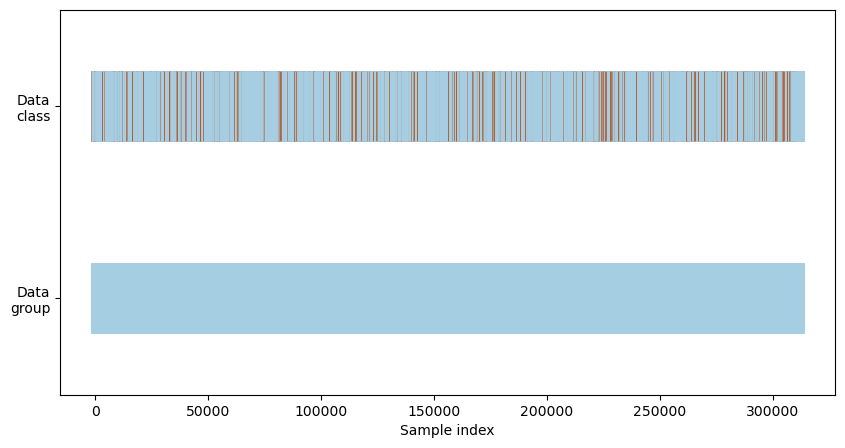

In [84]:
visualize_groups(train_y, groups, "no groups")

In [88]:
n_splits = 5
groups = None

/tmp/ipykernel_4107164/1298143750.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


<Axes: title={'center': 'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

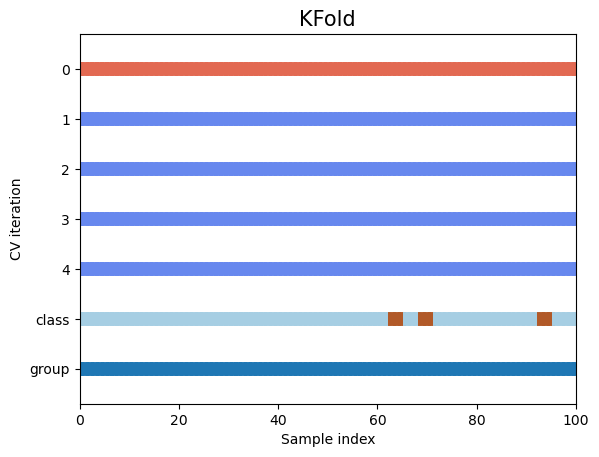

In [89]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, train_X, train_y, groups, ax, n_splits)

## Create balanced datasets

In [635]:
bal_train_X, bal_train_y = balance_datasets(train_X, train_y, ratio = 1)
bal_train_X_2, bal_train_y_2 = balance_datasets(train_X, train_y, ratio = 2)


 Take 12388 samples from total of 12388 negative training samples
 Take 12388 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 37164  Total len: 74328

 X :  Min: -27.6719    Max: 23.7271   Mean: 0.0016  Std: 1.0157
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000

 Take 12388 samples from total of 12388 negative training samples
 Take 24776 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 74328  Total len: 111492

 X :  Min: -27.3326    Max: 26.3826   Mean: 0.0014  Std: 1.0076
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714


In [636]:
bal_test_X, bal_test_y = balance_datasets(test_X, test_y, ratio = 1)
bal_test_X_2, bal_test_y_2 = balance_datasets(test_X, test_y, ratio = 2)


 Take 1388 samples from total of 1388 negative training samples
 Take 1388 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 4164  Total len: 8328

 X :  Min: -16.9431    Max: 19.0416   Mean: 0.0030  Std: 1.0028
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000

 Take 1388 samples from total of 1388 negative training samples
 Take 2776 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 8328  Total len: 12492

 X :  Min: -18.7677    Max: 20.9524   Mean: 0.0015  Std: 0.9780
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714


# **[Logistic Regression Model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)**

Intuitively, the `gamma` parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The `gamma`parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

The `C`parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of `C`, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words`C` behaves as a regularization parameter in the SVM.

### Parameters

In [33]:
try:
    del X_DATA, Y_DATA
except:
    pass
# train_y.head()

In [34]:
Best_Estimators = []
df_metrics = pd.DataFrame()

In [ ]:
X_DATA = df_train_x.iloc[:, 11:]    ## bal_train_X

X_DATA

In [45]:
NUM_JOBS = 1
RANDOM_STATE = 9999
Y_OFFSET = 3

In [46]:
Y_INDEX = 1
Y_DATA = df_train_y.iloc[:, Y_INDEX + Y_OFFSET] ## bal_train_y

In [48]:
Y_DATA.sum()

233172

In [75]:
# lr_grid_parameters = {'C': [0.1, 1, 10, 100, 200], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [  10,     5,   2,     1, 0.500, 0.250, 0.125], 'solver': ['lbfgs'],}
lr_grid_parameters = {'C': [1.1e+05, 1.0e+05, 7.5e+04, 5.0e+04, 2.5e+04, 1.25e+04], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e+04, 1.0e+04, 7.5e+03, 5.0e+03, 2.5e+03, 1.25e+03], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e+03, 1.0e+03, 7.5e+02, 5.0e+02, 2.5e+02, 1.25e+02], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e+02, 1.0e+02, 7.5e+01, 5.0e+01, 2.5e+01, 1.25e+01], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e+01, 1.0e+01, 7.5e+00, 5.0e+00, 2.5e+00, 1.25e+00], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e-00, 1.0e-00, 7.5e-01, 5.0e-01, 2.5e-01, 1.25e-01], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e-01, 1.0e-01, 7.5e-02, 5.0e-02, 2.5e-02, 1.25e-02], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e-02, 1.0e-02, 7.5e-03, 5.0e-03, 2.5e-03, 1.25e-03], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e-03, 1.0e-03, 7.5e-04, 5.0e-04, 2.5e-04, 1.25e-04], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e-04, 1.0e-04, 7.5e-05, 5.0e-05, 2.5e-05, 1.25e-05], 'solver': ['lbfgs'],}

# lr_grid_parameters = {'C': [1.1e+01, 1.0e+01, 7.5e+00, 5.0e+00, 2.5e+00, 1.25e+00 ,
#                             1.1e-00, 1.0e-00, 7.5e-01, 5.0e-01, 2.5e-01, 1.25e-01 ,
#                             1.1e-01, 1.0e-01, 7.5e-02, 5.0e-02, 2.5e-02, 1.25e-02 ,
#                             1.1e-02, 1.0e-02, 7.5e-03, 5.0e-03, 2.5e-03, 1.25e-03 ,
#                             1.1e-03, 1.0e-03, 7.5e-04, 5.0e-04, 2.5e-04, 1.25e-04 ,
#                             1.1e-04, 1.0e-04, 7.5e-05, 5.0e-05, 2.5e-05, 1.25e-05], 'solver': ['lbfgs'],}

In [76]:
PARM_SET = lr_grid_parameters
RANDOM_STATE
PARM_SET

9999

{'C': [110000.0, 100000.0, 75000.0, 50000.0, 25000.0, 12500.0],
 'solver': ['lbfgs']}

## Training

In [ ]:
logreg = LogisticRegression(penalty = 'l2', random_state = RANDOM_STATE, max_iter = 10000, tol = 1e-5, 
                            n_jobs = 5, class_weight=None, solver = 'lbfgs')

# vt_svm = model_selection(svc, PARM_SET, X_DATA, Y_DATA, scoring = 'roc_auc', cv=4, GridSearch = True, n_jobs=NUM_JOBS,  verbose = 3)
vt_logreg = model_selection(logreg, PARM_SET, X_DATA, Y_DATA, scoring = 'roc_auc', cv = 4,
                            GridSearch = True, n_jobs = NUM_JOBS, verbose = 3)

## Save best estimator and metrics

In [188]:
# Best_Estimators = []
_tmp_df = pd.DataFrame(vt_logreg.cv_results_)
_tmp_df['Y_bit'] = selected_label_indices[Y_INDEX]
_tmp_df['Y_bit_pct'] = bit_counter_pct[Y_INDEX]
_tmp_df['random_seed'] = RANDOM_STATE
reordered_col_names = ['Y_bit', 'rank_test_score',
                       'Y_bit_pct','mean_test_score', 'std_test_score', 'param_C', 'param_solver',
                       'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score',
                       'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
                       'params', 'random_seed']
_tmp_df = _tmp_df[reordered_col_names]
_tmp_df.shape
_tmp_df.sort_values('mean_test_score')

,Y_bit,rank_test_score,param_C,param_solver,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,random_seed
0,17,4,110.0,lbfgs,0.615141,0.001995,0.618158,0.613329,0.613355,0.615722,330.981190,11.976308,0.151455,0.001967,"{'C': 110.0, 'solver': 'lbfgs'}",9999
1,17,6,100.0,lbfgs,0.615133,0.001982,0.618131,0.613330,0.613362,0.615708,369.815080,20.996320,0.154113,0.004347,"{'C': 100.0, 'solver': 'lbfgs'}",9999
2,17,5,75.0,lbfgs,0.615140,0.001977,0.618116,0.613340,0.613360,0.615743,355.356028,60.021831,0.152441,0.004999,"{'C': 75.0, 'solver': 'lbfgs'}",9999
3,17,3,50.0,lbfgs,0.615141,0.001998,0.618155,0.613286,0.613383,0.615741,347.717348,40.835747,0.154706,0.004234,"{'C': 50.0, 'solver': 'lbfgs'}",9999
4,17,2,25.0,lbfgs,0.615147,0.001979,0.618130,0.613322,0.613391,0.615745,347.605311,31.904459,0.157820,0.005112,"{'C': 25.0, 'solver': 'lbfgs'}",9999
5,17,1,12.5,lbfgs,0.615156,0.001993,0.618157,0.613324,0.613381,0.615764,339.122218,13.248176,0.158102,0.008747,"{'C': 12.5, 'solver': 'lbfgs'}",9999


In [211]:
Best_Estimators
df_metrics.shape
df_metrics 
# df_metrics.sort_values('mean_test_score')

[]

(0, 0)

""


### Append best estimator and metrics

In [190]:
df_metrics = pd.concat((df_metrics, _tmp_df))
Best_Estimators.append((vt_logreg.best_estimator_, vt_logreg.best_params_))

In [191]:
Best_Estimators
df_metrics.shape
df_metrics.sort_values('mean_test_score')

[(LogisticRegression(C=0.125, max_iter=10000, n_jobs=5, random_state=42,
                     tol=1e-05),
  {'C': 0.125, 'solver': 'lbfgs'}),
 (LogisticRegression(C=0.0125, max_iter=10000, n_jobs=5, random_state=42,
                     tol=1e-05),
  {'C': 0.0125, 'solver': 'lbfgs'}),
 (LogisticRegression(C=0.0125, max_iter=10000, n_jobs=5, random_state=42,
                     tol=1e-05),
  {'C': 0.0125, 'solver': 'lbfgs'}),
 (LogisticRegression(C=0.0025, max_iter=10000, n_jobs=5, random_state=42,
                     tol=1e-05),
  {'C': 0.0025, 'solver': 'lbfgs'}),
 (LogisticRegression(C=0.0025, max_iter=10000, n_jobs=5, random_state=9999,
                     tol=1e-05),
  {'C': 0.0025, 'solver': 'lbfgs'}),
 (LogisticRegression(C=12.5, max_iter=10000, n_jobs=5, random_state=9999,
                     tol=1e-05),
  {'C': 12.5, 'solver': 'lbfgs'})]

(42, 16)

,Y_bit,rank_test_score,param_C,param_solver,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,random_seed
1,17,6,100.0,lbfgs,0.615133,0.001982,0.618131,0.613330,0.613362,0.615708,369.815080,20.996320,0.154113,0.004347,"{'C': 100.0, 'solver': 'lbfgs'}",9999
1,17,6,10.0,lbfgs,0.615136,0.001977,0.618117,0.613310,0.613387,0.615729,496.507097,37.383651,0.321792,0.057830,"{'C': 10.0, 'solver': 'lbfgs'}",42
2,17,5,7.5,lbfgs,0.615139,0.001977,0.618117,0.613318,0.613383,0.615738,465.068859,46.319405,0.231491,0.037334,"{'C': 7.5, 'solver': 'lbfgs'}",42
2,17,5,75.0,lbfgs,0.615140,0.001977,0.618116,0.613340,0.613360,0.615743,355.356028,60.021831,0.152441,0.004999,"{'C': 75.0, 'solver': 'lbfgs'}",9999
0,17,4,110.0,lbfgs,0.615141,0.001995,0.618158,0.613329,0.613355,0.615722,330.981190,11.976308,0.151455,0.001967,"{'C': 110.0, 'solver': 'lbfgs'}",9999
3,17,3,50.0,lbfgs,0.615141,0.001998,0.618155,0.613286,0.613383,0.615741,347.717348,40.835747,0.154706,0.004234,"{'C': 50.0, 'solver': 'lbfgs'}",9999
4,17,2,25.0,lbfgs,0.615147,0.001979,0.618130,0.613322,0.613391,0.615745,347.605311,31.904459,0.157820,0.005112,"{'C': 25.0, 'solver': 'lbfgs'}",9999
0,17,4,11.0,lbfgs,0.615147,0.001999,0.618168,0.613306,0.613381,0.615734,464.265326,28.127619,0.211163,0.029004,"{'C': 11.0, 'solver': 'lbfgs'}",42
3,17,3,5.0,lbfgs,0.615155,0.001983,0.618148,0.613332,0.613395,0.615745,400.928198,32.060230,0.178681,0.010758,"{'C': 5.0, 'solver': 'lbfgs'}",42
5,17,1,12.5,lbfgs,0.615156,0.001993,0.618157,0.613324,0.613381,0.615764,339.122218,13.248176,0.158102,0.008747,"{'C': 12.5, 'solver': 'lbfgs'}",9999


In [161]:
# Best_Estimators = []
# _tmp_df = df_metrics
# _tmp_df['Y_bit'] = selected_label_indices[Y_INDEX]
# reordered_col_names = ['Y_bit', 'rank_test_score', 'param_C', 'param_solver', 'mean_test_score', 'std_test_score', 
#                        'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_fit_time',
#                        'std_fit_time', 'mean_score_time', 'std_score_time', 'params']
# _tmp_df = _tmp_df[reordered_col_names]
# _tmp_df

# df_metrics = _tmp_df
# df_metrics['random_seed'] = 42

## Metric results

In [ ]:
# Best parameters set found on development set: {'C': 0.125, 'solver': 'lbfgs'}
# Best score: 0.5483
# Grid scores on development set:
# Best parameters set found on development set: {'C': 0.012, 'solver': 'lbfgs'}
# Best score: 0.5493 
# Grid scores on development set:
# Best parameters set found on development set: {'C': 0.00125, 'solver': 'lbfgs'}
# Best score: 0.5513
# Grid scores on development set:
Best parameters set found on development set: {'C': 0.000125, 'solver': 'lbfgs'}
Best score: 0.5526 
Grid scores on development set:

# 0.54795 (+/-0.006) for {'C': 10, 'solver': 'lbfgs'}
# 0.54796 (+/-0.006) for {'C': 5, 'solver': 'lbfgs'}
# 0.54798 (+/-0.006) for {'C': 2, 'solver': 'lbfgs'}
# 0.54799 (+/-0.006) for {'C': 1, 'solver': 'lbfgs'}
# 0.54805 (+/-0.006) for {'C': 0.5, 'solver': 'lbfgs'}
# 0.54814 (+/-0.006) for {'C': 0.25, 'solver': 'lbfgs'}
# 0.54828 (+/-0.006) for {'C': 0.125, 'solver': 'lbfgs'}
# 0.54816 (+/-0.006) for {'C': 0.2, 'solver': 'lbfgs'}
# 0.54828 (+/-0.006) for {'C': 0.125, 'solver': 'lbfgs'}
# 0.54833 (+/-0.006) for {'C': 0.1, 'solver': 'lbfgs'}
# 0.54842 (+/-0.006) for {'C': 0.075, 'solver': 'lbfgs'}
# 0.54855 (+/-0.006) for {'C': 0.05, 'solver': 'lbfgs'}
# 0.54886 (+/-0.006) for {'C': 0.025, 'solver': 'lbfgs'}
# 0.54931 (+/-0.007) for {'C': 0.012, 'solver': 'lbfgs'}

# 0.54931 (+/-0.007) for {'C': 0.012, 'solver': 'lbfgs'}
# 0.54944 (+/-0.007) for {'C': 0.01, 'solver': 'lbfgs'}
# 0.54965 (+/-0.007) for {'C': 0.0075, 'solver': 'lbfgs'}
# 0.55000 (+/-0.007) for {'C': 0.005, 'solver': 'lbfgs'}
# 0.55063 (+/-0.007) for {'C': 0.0025, 'solver': 'lbfgs'}
# 0.55129 (+/-0.007) for {'C': 0.00125, 'solver': 'lbfgs'}

# 0.55133 (+/-0.007) for {'C': 0.0012, 'solver': 'lbfgs'}
# 0.55151 (+/-0.007) for {'C': 0.001, 'solver': 'lbfgs'}
# 0.55177 (+/-0.006) for {'C': 0.00075, 'solver': 'lbfgs'}
# 0.55211 (+/-0.006) for {'C': 0.0005, 'solver': 'lbfgs'}
# 0.55254 (+/-0.006) for {'C': 0.00025, 'solver': 'lbfgs'}
# 0.55263 (+/-0.005) for {'C': 0.000125, 'solver': 'lbfgs'}

# 0.55263 (+/-0.005) for {'C': 0.00012, 'solver': 'lbfgs'}
# 0.55259 (+/-0.005) for {'C': 0.0001, 'solver': 'lbfgs'}
# 0.55248 (+/-0.005) for {'C': 7.5e-05, 'solver': 'lbfgs'}
# 0.55219 (+/-0.005) for {'C': 5e-05, 'solver': 'lbfgs'}
# 0.55125 (+/-0.004) for {'C': 2.5e-05, 'solver': 'lbfgs'}
# 0.54241 (+/-0.004) for {'C': 1.25e-06, 'solver': 'lbfgs'}

In [106]:
# vt_logreg
# vt_logreg.best_estimator_
# vt_logreg.best_index_
# vt_logreg.best_params_
# vt_logreg.best_score_
# vt_logreg.classes_
# vt_logreg.cv
vt_logreg.cv_results_
# vt_logreg.decision_function
# vt_logreg.error_score
# vt_logreg.estimator
# vt_logreg.fit
# vt_logreg.get_metadata_routing()
print('-'*40)
print(f"vt_svm parameters: ")
vt_logreg.get_params()
print('-'*40)
# df_metrics  = pd.DataFrame(vt_logreg.cv_results_)

{'mean_fit_time': array([464.2653262 , 496.50709653, 465.06885934, 400.9281984 , 374.74507344, 324.49689734]),
 'std_fit_time': array([28.12761903, 37.38365113, 46.31940523, 32.06022955, 26.04696725, 22.09064349]),
 'mean_score_time': array([0.21116334, 0.32179183, 0.23149091, 0.17868078, 0.18570018, 0.17660046]),
 'std_score_time': array([0.02900353, 0.05782952, 0.0373342 , 0.01075786, 0.01544511, 0.00793135]),
 'param_C': masked_array(data=[11.0, 10.0, 7.5, 5.0, 2.5, 1.25],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 11.0, 'solver': 'lbfgs'},
  {'C': 10.0, 'solver': 'lbfgs'},
  {'C': 7.5, 'solver': 'lbfgs'},
  {'C': 5.0, 'solver': 'lbfgs'},
  {'C': 2.5, 'solver': 'lbfgs'},
  {'C': 1.25, 'solver

----------------------------------------
vt_svm parameters: 


{'cv': 4,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 10000,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': 5,
 'estimator__penalty': 'l2',
 'estimator__random_state': 42,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 1e-05,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(max_iter=10000, n_jobs=5, random_state=42, tol=1e-05),
 'n_jobs': 1,
 'param_grid': {'C': [11.0, 10.0, 7.5, 5.0, 2.5, 1.25], 'solver': ['lbfgs']},
 'pre_dispatch': 1,
 'refit': True,
 'return_train_score': False,
 'scoring': 'roc_auc',
 'verbose': 3}

----------------------------------------


## Save Model

In [192]:
MODEL_SAVE_PATH = './saved_fingerprint_models/profile_models'
ESTIMATORS_FILENAME = f'PFP_LogReg_profiles_Y_Bit_{selected_label_indices[Y_INDEX]}_20241101_0700.pkl'
ESTIMATORS_FILENAME
METRICS_FILENAME = f'PFP_LogReg_prfoiles_Y_Bit_{selected_label_indices[Y_INDEX]}_20241101_0700_metrics.csv'
METRICS_FILENAME

'PFP_LogReg_profiles_Y_Bit_17_20241101_0700.pkl'

'PFP_LogReg_prfoiles_Y_Bit_17_20241101_0700_metrics.csv'

In [193]:
save_to_pickle(Best_Estimators, '', ESTIMATORS_FILENAME, verbose = True)

 save_to_pickle(): save data to PFP_LogReg_profiles_Y_Bit_17_20241101_0700.pkl


In [194]:
df_metrics.to_csv(METRICS_FILENAME)

## Load Model

In [1]:
# os.path.exists('./saved_fingerprint_models/')
# os.path.exists('./saved_fingerprint_models/profile_models')
# os.path.exists('./saved_fingerprint_models/profile_models/PFP_LogReg_profiles_Y_Bit_17_20241101_0700.pkl')

In [67]:
Y_INDEX = 17
MODEL_SAVE_PATH = './saved_fingerprint_models/profile_models'
ESTIMATORS_FILENAME = f'PFP_LogReg_profiles_Y_Bit_{Y_INDEX}_20241101_0700.pkl'
ESTIMATORS_FILENAME
METRICS_FILENAME = f'PFP_LogReg_profiles_Y_Bit_{Y_INDEX}_20241101_0700_metrics.csv'
METRICS_FILENAME

'PFP_LogReg_profiles_Y_Bit_17_20241101_0700.pkl'

'PFP_LogReg_profiles_Y_Bit_17_20241101_0700_metrics.csv'

In [68]:
Best_Estimators = load_from_pickle(MODEL_SAVE_PATH, ESTIMATORS_FILENAME)

In [69]:
Best_Estimators

lr_estimators = Best_Estimators[-1]
lr_estimators
print(f"parameters   :")
pp.pprint(lr_estimators[0].get_params())
print()
lr_estimators[0].__dict__

[(LogisticRegression(C=0.125, max_iter=10000, n_jobs=5, random_state=42,
                     tol=1e-05),
  {'C': 0.125, 'solver': 'lbfgs'}),
 (LogisticRegression(C=0.0125, max_iter=10000, n_jobs=5, random_state=42,
                     tol=1e-05),
  {'C': 0.0125, 'solver': 'lbfgs'}),
 (LogisticRegression(C=0.0125, max_iter=10000, n_jobs=5, random_state=42,
                     tol=1e-05),
  {'C': 0.0125, 'solver': 'lbfgs'}),
 (LogisticRegression(C=0.0025, max_iter=10000, n_jobs=5, random_state=42,
                     tol=1e-05),
  {'C': 0.0025, 'solver': 'lbfgs'}),
 (LogisticRegression(C=0.0025, max_iter=10000, n_jobs=5, random_state=9999,
                     tol=1e-05),
  {'C': 0.0025, 'solver': 'lbfgs'}),
 (LogisticRegression(C=12.5, max_iter=10000, n_jobs=5, random_state=9999,
                     tol=1e-05),
  {'C': 12.5, 'solver': 'lbfgs'})]

(LogisticRegression(C=12.5, max_iter=10000, n_jobs=5, random_state=9999,
                    tol=1e-05),
 {'C': 12.5, 'solver': 'lbfgs'})

parameters   :
{   'C': 12.5,
    'class_weight': None,
    'dual': False,
    'fit_intercept': True,
    'intercept_scaling': 1,
    'l1_ratio': None,
    'max_iter': 10000,
    'multi_class': 'auto',
    'n_jobs': 5,
    'penalty': 'l2',
    'random_state': 9999,
    'solver': 'lbfgs',
    'tol': 1e-05,
    'verbose': 0,
    'warm_start': False}



{'penalty': 'l2',
 'dual': False,
 'tol': 1e-05,
 'C': 12.5,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'class_weight': None,
 'random_state': 9999,
 'solver': 'lbfgs',
 'max_iter': 10000,
 'multi_class': 'auto',
 'verbose': 0,
 'warm_start': False,
 'n_jobs': 5,
 'l1_ratio': None,
 'feature_names_in_': array(['Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', ...,
        'Nuclei_Texture_SumVariance_ER_10_01_256', 'Nuclei_Texture_SumVariance_Mito_10_03_256', 'Nuclei_Texture_SumVariance_RNA_10_01_256'],
       dtype=object),
 'n_features_in_': 1471,
 'classes_': array([0, 1]),
 'n_iter_': array([1699], dtype=int32),
 'coef_': array([[ 0.01892892,  0.02035189, -0.09238111, ..., -0.02118095,  0.00857472, -0.00314008]]),
 'intercept_': array([0.67875176])}

In [71]:
df_metrics = pd.read_csv(os.path.join(MODEL_SAVE_PATH, METRICS_FILENAME))

In [74]:
df_metrics.shape
# df_metrics.sort_values('mean_test_score')
df_metrics

(42, 17)

,Unnamed: 0,Y_bit,rank_test_score,param_C,param_solver,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,random_seed
0,0,17,4,11.00000,lbfgs,0.615147,0.001999,0.618168,0.613306,0.613381,0.615734,464.265326,28.127619,0.211163,0.029004,"{'C': 11.0, 'solver': 'lbfgs'}",42
1,1,17,6,10.00000,lbfgs,0.615136,0.001977,0.618117,0.613310,0.613387,0.615729,496.507097,37.383651,0.321792,0.057830,"{'C': 10.0, 'solver': 'lbfgs'}",42
2,2,17,5,7.50000,lbfgs,0.615139,0.001977,0.618117,0.613318,0.613383,0.615738,465.068859,46.319405,0.231491,0.037334,"{'C': 7.5, 'solver': 'lbfgs'}",42
3,3,17,3,5.00000,lbfgs,0.615155,0.001983,0.618148,0.613332,0.613395,0.615745,400.928198,32.060230,0.178681,0.010758,"{'C': 5.0, 'solver': 'lbfgs'}",42
4,4,17,2,2.50000,lbfgs,0.615185,0.001987,0.618172,0.613363,0.613405,0.615799,374.745073,26.046967,0.185700,0.015445,"{'C': 2.5, 'solver': 'lbfgs'}",42
5,5,17,1,1.25000,lbfgs,0.615208,0.001996,0.618206,0.613380,0.613413,0.615831,324.496897,22.090643,0.176600,0.007931,"{'C': 1.25, 'solver': 'lbfgs'}",42
6,0,17,6,1.10000,lbfgs,0.615208,0.001991,0.618197,0.613379,0.613424,0.615834,381.462832,76.880972,0.189637,0.022709,"{'C': 1.1, 'solver': 'lbfgs'}",42
7,1,17,5,1.00000,lbfgs,0.615217,0.002002,0.618227,0.613382,0.613422,0.615837,310.152655,15.569114,0.173652,0.010660,"{'C': 1.0, 'solver': 'lbfgs'}",42
8,2,17,4,0.75000,lbfgs,0.615246,0.002000,0.618265,0.613435,0.613440,0.615843,315.830231,11.294061,0.159021,0.000790,"{'C': 0.75, 'solver': 'lbfgs'}",42
9,3,17,3,0.50000,lbfgs,0.615275,0.002015,0.618333,0.613412,0.613516,0.615841,275.422085,10.861293,0.160437,0.001217,"{'C': 0.5, 'solver': 'lbfgs'}",42


## Metrics -

In [49]:
FILENAME = 'PFP_LogReg_estimator_RawProfiles_20241030_1500.pkl'
lr_estimators = load_from_pickle('', FILENAME)

In [51]:
# print(f"parameters   :")
# pp.pprint(svm_estimators.get_params())
print(f"best_estimator_  :   {lr_estimators.best_estimator_}")
print()
 

best_estimator_  :   LogisticRegression(C=0.125, max_iter=10000, n_jobs=5, random_state=42,
                   tol=1e-05)



In [62]:
TEST_X = test_x.iloc[:, 1:]    ## bal_train_X
TEST_Y = test_y.iloc[:, 0] ## bal_train_y


In [64]:
y_pred = lr_estimators.best_estimator_.predict(TEST_X)
y_pred.shape

(12600,)

In [648]:
# bal_y_pred = svm_estimators.best_estimator_.predict(bal_test_X)
# bal_y_pred.shape

(8328,)

In [65]:
# label_counts( [("Ground Truth", test_y), ("Predictions", y_pred), ("Balanced Ground Truth", bal_test_y), ("Balanced Predictions", bal_test_y)])
label_counts( [("Ground Truth", TEST_Y), ("Predictions", y_pred)])

 Ground Truth
 Total samples: 12600
 Label 0:   6,312      % 50.10 
 Label 1:   6,288      % 49.90 

 Predictions
 Total samples: 12600
 Label 0:   4,741      % 37.63 
 Label 1:   7,859      % 62.37 



In [66]:
compute_metrics(TEST_Y, y_pred)

 Accuracy: 0.53675     Precision: 0.52869     Recall: 0.66078     F1: 0.58740 

 True + labels:          6288     ratio to total:  0.49905
 Predicted + labels:     7859     ratio to total:  0.62373
 True/Predicted Match:   6763     ratio to total:  0.53675


In [67]:
# compute_metrics(bal_test_y, bal_y_pred, " 1:1 Balanced test file")

In [68]:
# plots_from_estimator(svm_estimators.best_estimator_, test_X, y_pred)
# plots_from_estimator(svm_estimators.best_estimator_, bal_test_X, bal_y_pred)

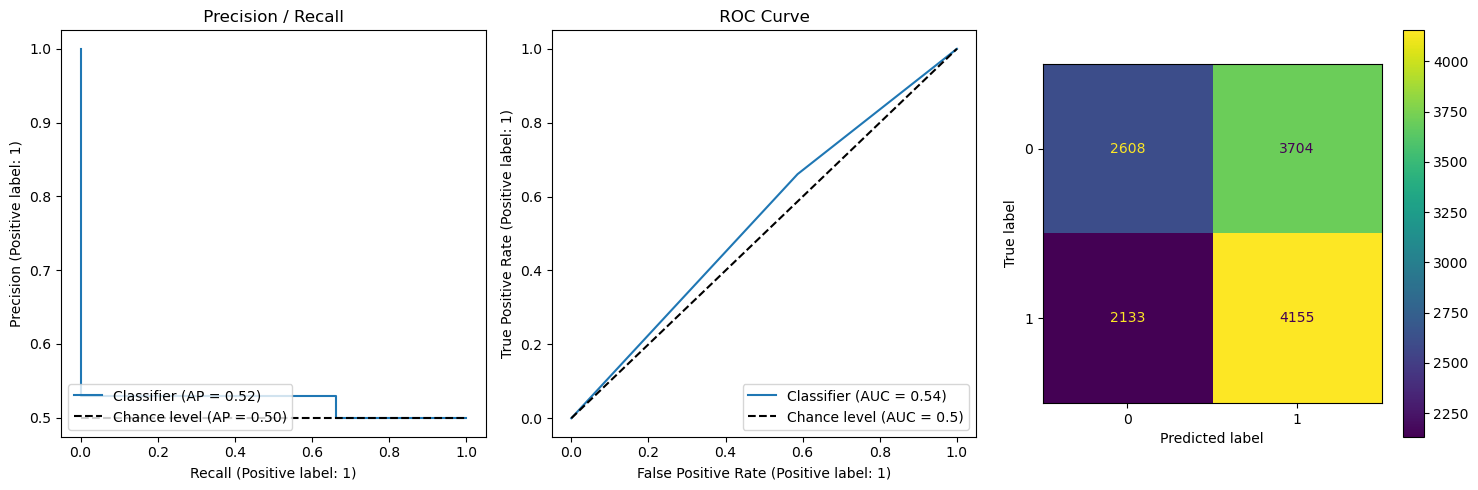

In [69]:
plots_from_predictions(TEST_Y, y_pred)
# plots_from_predictions(bal_test_y, bal_y_pred)